# Interaction with MSNoise and plotting dv/v

## Importing modules and libraries

In [1]:
#import msnoise.api as ms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import csv
import datetime
import scipy

## Interacting with MSNoise

In [ ]:
# Connecting to the database of MSNoise

path_ini = 'D:\\MEMOIRE\\MSNoise\\master\\db.ini'
database = ms.connect(inifile=path_ini)

In [ ]:
NET = ms.get_networks(database)
STA = ['BJK','DJK','HUS','VOT','JOK','KSK','URH','GRF','KVI']

In [ ]:
for sta in STA :
    ms.mark_data_availability(database, 'VI', sta, 'A')
ms.is_next_job(database, flag='T', jobtype='CC')

In [ ]:
#ms.get_filters(database, all=True)

In [ ]:
#ms.update_filter(database,ref=2,low=1.0,high=2.0,mwcs_low=1.0,mwcs_high=2.0, mwcs_wlen=120, 
                     mwcs_step=60 , rms_threshold=0, used=True)

## Making functions

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [44]:
def extracting_M(root) :
    '''
    root = 'D:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
    
    '''
    folder = os.listdir(root)
    
    pair = []
    M0 = []
    date = []
    NY = []
    idxNY = []

    ALLM = []
    ALLEM = []

    frt = '%Y-%m-%d'

    X = list(range(len(folder)))
    Y = list(range(len(pair_name)))

    xv, yv = np.meshgrid(X, Y)
    line = 0

    m = np.zeros(xv.shape)+999 #creating a empty initial list of 999
    #print(m)

    for file in folder :
        df = pd.read_csv(root+file)
        tpair = df['Pairs'].tolist() # extrating pairs
        tdate = df['Date'].tolist() #extraction dates
        tM = df['M'].tolist() #extracting slope
        tEM = df['EM'].tolist()
        if line == 0 :
            sttdate = datetime.datetime.strptime(tdate[0],frt)
        currdate = datetime.datetime.strptime(tdate[0],frt)
        date.append(currdate)
        posdate = currdate - sttdate
        posdate = int(posdate.days) # determine the date position
        if currdate.day == 1 and currdate.month == 1 :
            NY.append(currdate)
            idxNY.append(posdate)
        #print(int(posdate.days))
        line += 1

        for ti in range(len(tpair)) :
            if tpair[ti] != 'ALL' :
                idx = pair_name.index(tpair[ti])
                m[idx][posdate] = float(tM[ti])
            if tpair[ti] == 'ALL' :
                ALLM.append(float(tM[ti]))
                ALLEM.append(float(tEM[ti]))
        m = np.where(m == 999, np.nan, m)
        
    return ALLM, ALLEM, date, m, NY, idxNY

## dvv plotting

### Specify the root of dtt files and pair station names

In [53]:
component = 'ZZ'
mwlength = '030'
filterID = '07'
frqlen = '0.5-1.0Hz'
# Root of the dtt files to plot
root = 'E:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
folder = os.listdir(root)
# Root of the stations pairs names
rootpair = 'E:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
pair_name = os.listdir(rootpair)

### Example of a dtt files

In [54]:
df = pd.read_csv(root+folder[0])

In [55]:
df

,Date,Pairs,M,EM,A,EA,M0,EM0
0,2018-01-01,VI_BJK_VI_DJK,-0.001306,0.001253,0.074952,0.021103,0.002791,0.000840
1,2018-01-01,VI_BJK_VI_GRF,0.000938,0.000777,-0.032852,0.009962,0.000799,0.001204
2,2018-01-01,VI_BJK_VI_URH,0.000157,0.000833,0.060827,0.015363,0.001922,0.001707
3,2018-01-01,VI_DJK_VI_GRF,0.001251,0.000544,-0.049011,0.010011,0.001888,0.001371
4,2018-01-01,VI_GRF_VI_URH,0.000950,0.001384,0.016298,0.022445,0.001055,0.001310
5,2018-01-01,ALL,0.000778,0.000918,-0.020686,0.018620,0.000316,0.000830


### Extracting the data from each dtt files

In [56]:
ALLM, ALLEM, date, m, NY, idxNY = extracting_M(root)

### Plotting mean curve with error

Text(0.5, 1.0, 'FFT :\n Filter 07 : 0.5-1.0Hz - 030 days moving window')

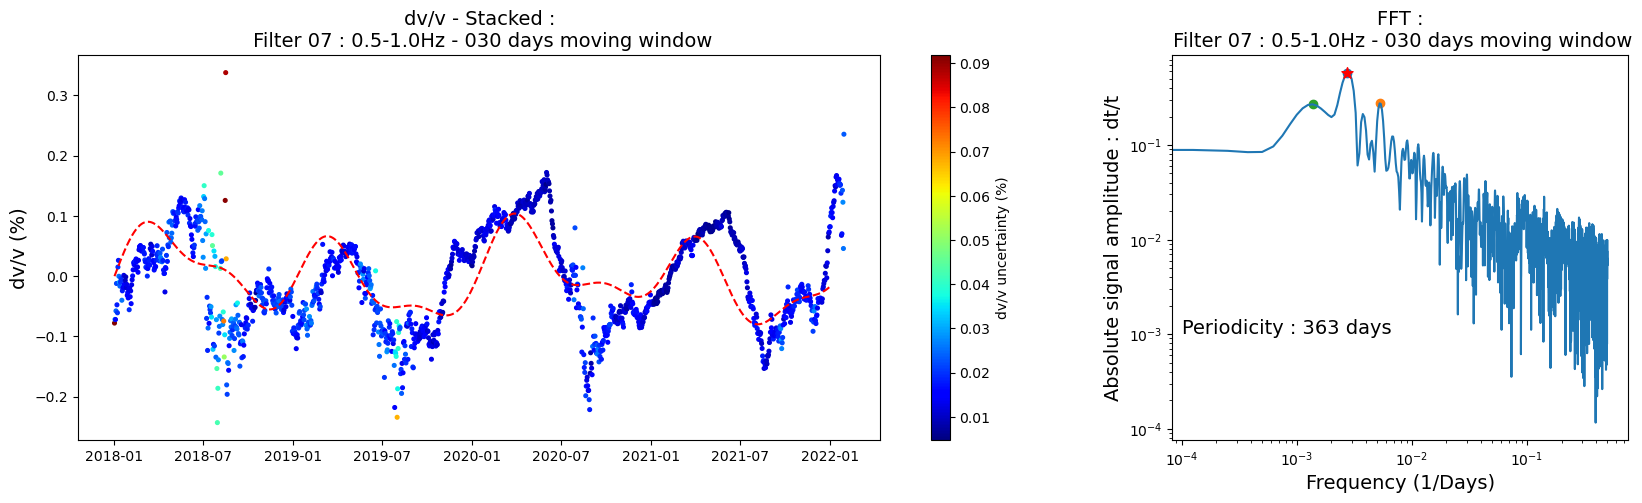

In [57]:
modelling = True

Yfft = np.fft.rfft(np.array(ALLM),n=8000)
frq =  np.fft.rfftfreq(8001)

Yfft = np.abs(Yfft)
frq = frq


fig = plt.figure(figsize=(20,5))
ax1 = plt.subplot2grid((1,3), (0,0), colspan=2)
dplot = ax1.scatter(date,np.array(ALLM)*-100, c=np.array(ALLEM)*100, cmap='jet',s=7)
ax1.set_ylabel('dv/v (%)', fontsize=14)
fig.colorbar(dplot, label='dv/v uncertainty (%)')

ax1.set_title('dv/v - Stacked :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='14')

ax2 = plt.subplot2grid((1,3), (0,2), colspan=1)
ax2.plot(frq,Yfft)

if np.argmax(Yfft) != 0 :
    ax2.scatter(frq[np.argmax(Yfft)],np.max(Yfft), zorder=10,c='r', marker='*', s=70)
    ax2.text(1e-4, 1e-3, 'Periodicity : %i days' %(1/frq[np.argmax(Yfft)]), fontsize=14)
else :
    ax2.scatter(frq[np.argmax(Yfft[10:])+10],np.max(Yfft[10:]), zorder=10,c='r', marker='*', s=70)
    ax2.text(1e-4, 1e-3, 'Periodicity : %i days' %(1/frq[np.argmax(Yfft[10:])+10]), fontsize=14)
    ax2.plot([frq[10],frq[10]], [np.min(Yfft)-0.0001,np.max(Yfft)+0.1], c='r', ls='--')
    ax2.set_ylim(np.min(Yfft)-0.0001,np.max(Yfft)+0.1)
    
#plt.ylim(-0.05,0.05)
ax2.set_yscale('log')
ax2.set_xscale('log')
#plt.xlim(0,700)

if modelling == True :

    datemod = np.arange(np.datetime64('2018-01-01'),np.datetime64('2022-01-01'))
    xmod = np.arange(0,datemod.size)
    ffrq = 1/frq[np.argmax(Yfft)]
    ax2.scatter(1/ffrq,np.max(Yfft))
    sfrq = 1/frq[np.argmax(Yfft[30:])+30]
    ax2.scatter(1/sfrq, np.max(Yfft[30:]))
    tfrq = 1/frq[np.argmax(Yfft[0:15])]
    ax2.scatter(1/tfrq, np.max(Yfft[0:15]))
    ymod =  np.max(Yfft)/10*np.sin(2*3.14*xmod/ffrq) + np.max(Yfft[30:])/10*np.sin(2*3.14*xmod/sfrq) + np.max(Yfft[0:15])/10*np.sin(2*3.14*xmod/tfrq)

    ax1.plot(datemod, ymod, c='r', ls='--')

ax2.set_xlabel('Frequency (1/Days)', fontsize=14)
ax2.set_ylabel('Absolute signal amplitude : dt/t', fontsize=14)
ax2.set_title('FFT :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='14')


#plt.savefig('./plot_interfero/dvv-ALL-f%s.png' %(filterID), bbox_inches='tight')

## Plotting FFT

Text(0.5, 1.0, 'FFT :\n Filter 07 : 0.5-1.0Hz - 030 days moving window')

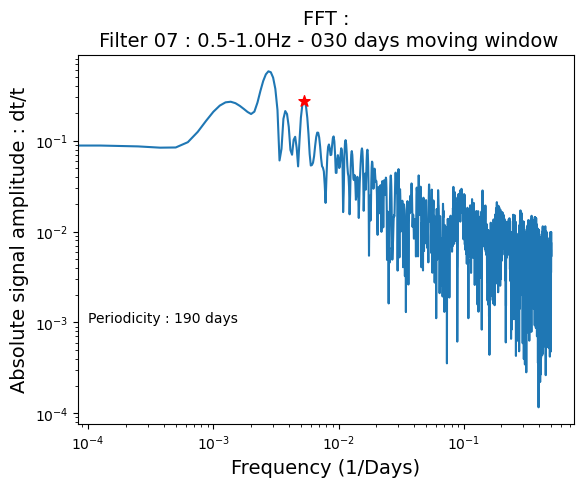

In [58]:
secondpeak = True

Yfft = np.fft.rfft(np.array(ALLM),n=8000)
frq =  np.fft.rfftfreq(8001)

Yfft = np.abs(Yfft)
frq = frq

if secondpeak == True :
    plt.scatter(frq[np.argmax(Yfft[30:])+30],np.max(Yfft[30:]), zorder=10,c='r', marker='*', s=70)
    plt.text(1e-4, 1e-3, 'Periodicity : %i days' %(1/frq[np.argmax(Yfft[30:])+30]))
if secondpeak == False :
    plt.scatter(frq[np.argmax(Yfft)],np.max(Yfft), zorder=10,c='r', marker='*', s=70)
    plt.text(1e-4, 1e-3, 'Periodicity : %i days' %(1/frq[np.argmax(Yfft)]))

plt.plot(frq,Yfft)


#plt.ylim(-0.05,0.05)
plt.yscale('log')
plt.xscale('log')
#plt.xlim(0,700)

plt.xlabel('Frequency (1/Days)', fontsize=14)
plt.ylabel('Absolute signal amplitude : dt/t', fontsize=14)
plt.title('FFT :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='14')
#plt.xscale('log')

### Plotting the data with pcolormesh

In [59]:
tX = list(range(len(folder)))
tY = list(range(len(pair_name)))

xv, yv = np.meshgrid(tX, tY)

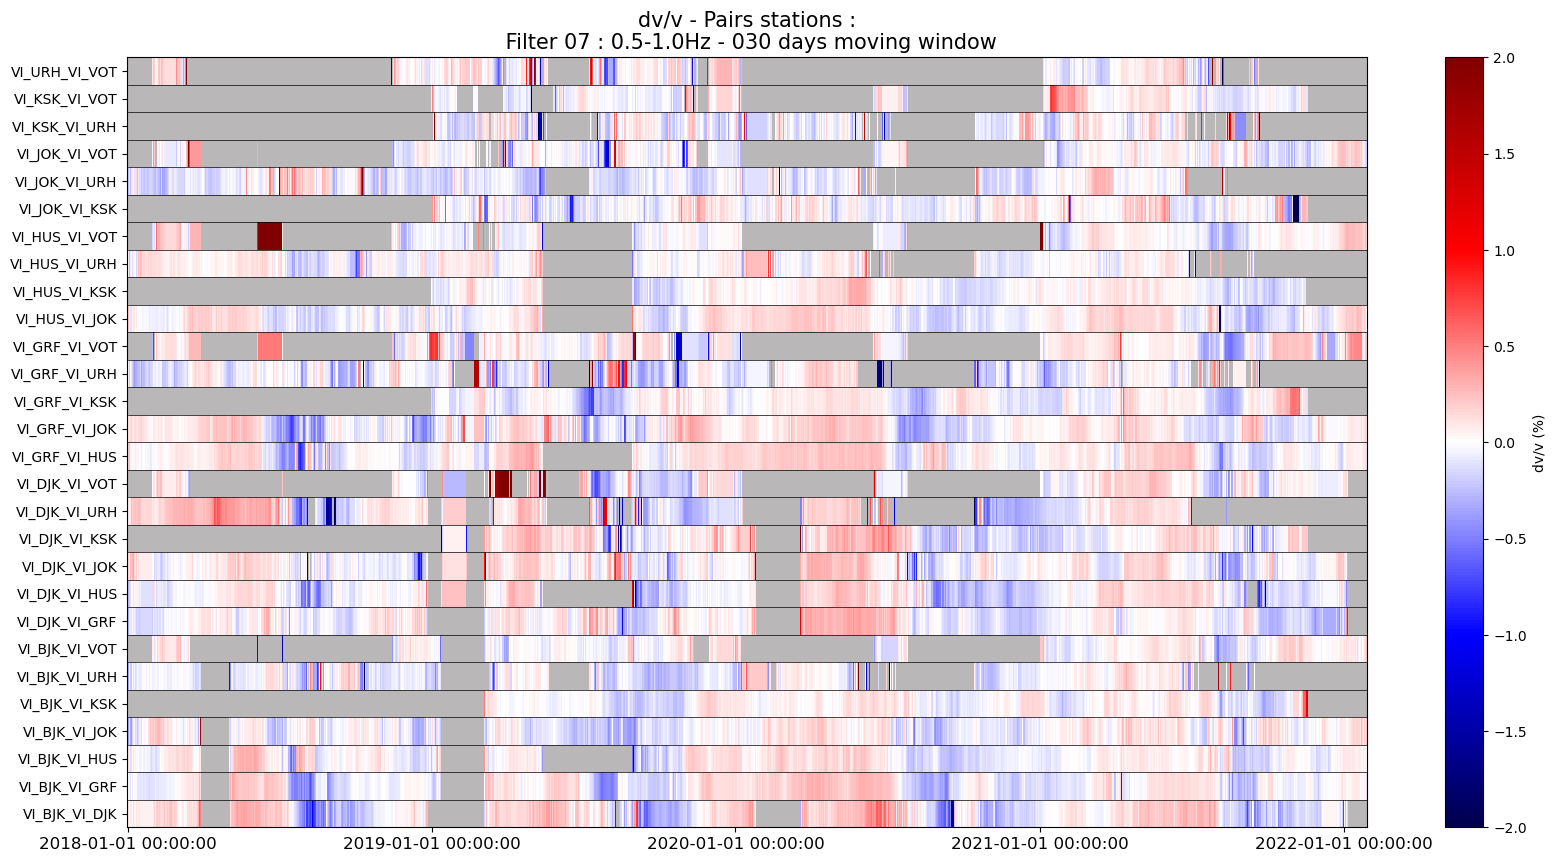

In [60]:
from matplotlib import colors

plt.figure(figsize=(20,10))
ax = plt.axes()
ax.set_facecolor("#B9B7B7")
norm = colors.Normalize(vmin=-2,vmax=2)
#norm = colors.CenteredNorm()
plt.pcolormesh(xv,yv,m*-100, norm=norm, cmap='seismic')
for i in range(len(pair_name)) :
    temp = np.array([tX[0],tX[-1]])
    plt.plot(temp, [i-.5,i-.5], c='black',linewidth = .5)
plt.yticks(ticks=tY,labels=pair_name)
plt.xticks(ticks=idxNY,labels=NY, fontsize='12')
plt.title('dv/v - Pairs stations :\n Filter %s : %s - %s days moving window' %(filterID, frqlen, mwlength ),
          fontsize='15')
plt.colorbar(label='dv/v (%)')
#plt.savefig('./plot_interfero/dvv-f%s-%s_%sd.png' %(filterID, frqlen, mwlength ), bbox_inches='tight')
plt.show()

## Comparing Frequency bands - Time lag

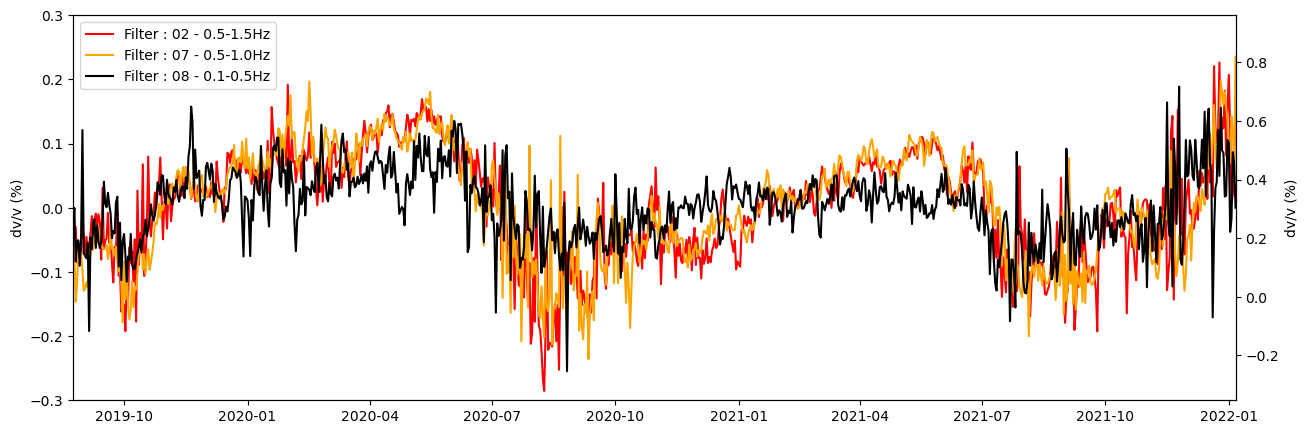

In [65]:
component = 'ZZ'
mwlength = '007'
fig, ax1 = plt.subplots(figsize=(15,5))
ax2 = ax1.twinx() 

color = ['red','orange','k']
bf = ['0.5-1.5Hz','0.5-1.0Hz', '0.1-0.5Hz']
for i, f in enumerate(['02','07','08']) :
    


    
    filterID = f
    #frqlen = '7.5-10.0Hz'
    # Root of the dtt files to plot
    root = 'E:/MEMOIRE/MsNoise/ablation/DTT/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
    folder = os.listdir(root)
    # Root of the stations pairs names
    rootpair = 'E:/MEMOIRE/MSNoise/ablation/MWCS/%s/%s_DAYS/%s/' %(filterID, mwlength, component)
    pair_name = os.listdir(rootpair)
    
    ALLM, ALLEM, date, m, NY, idxNY = extracting_M(root)
    
    ax1.plot(date, -100*np.array(ALLM)+0*0.3, label='Filter : %s - %s' %(filterID, bf[i]), c=color[i])
    ax2.plot(date, -100*np.array(ALLM)+0*0.3, label='Filter : %s' %filterID, visible=False)
    
    #for j in range(4) :
    #    posmin = find_nearest(np.array(date).astype('datetime64'), np.datetime64('20%i-05-01'%(18+j)))
    #    posmax = find_nearest(np.array(date).astype('datetime64'), np.datetime64('20%i-09-15'%(18+j)))   
        
    #    Xmax = np.argmax(ALLM[posmin:posmax])
        #Ymax = np.max(ALLM[posmin:posmax])
        #Ymin = np.argmin(ALLM[posmin:posmax])
    #    Xmin = np.argmin(ALLM[posmin:posmax])


    #    plt.plot([date[Xmin+posmin],date[Xmin+posmin]], [-0.3+(0.3*i),0.3+(0.3*i)], c='r', ls='--')
    #    plt.plot([date[Xmax+posmin],date[Xmax+posmin]], [-0.3+(0.3*i),0.3+(0.3*i)], c='green', ls='--')

ax1.set_ylabel('dv/v (%)')
ax2.set_ylabel('dv/v (%)')
    
#ax1.set_yticks([-0.2,0,0.2,0.4,0.6,0.8],[-0.2,0,0.2,-0.2,0,0.2])    
   
#ax2.set_yticks([0.1,0.3,0.5],[-0.2,0,0.2])
ax1.set_xlim(date[600], date[-1])
ax1.set_ylim(-0.3,0.3)
ax1.legend()